# Implementation of baselines

#### See Section VI-B

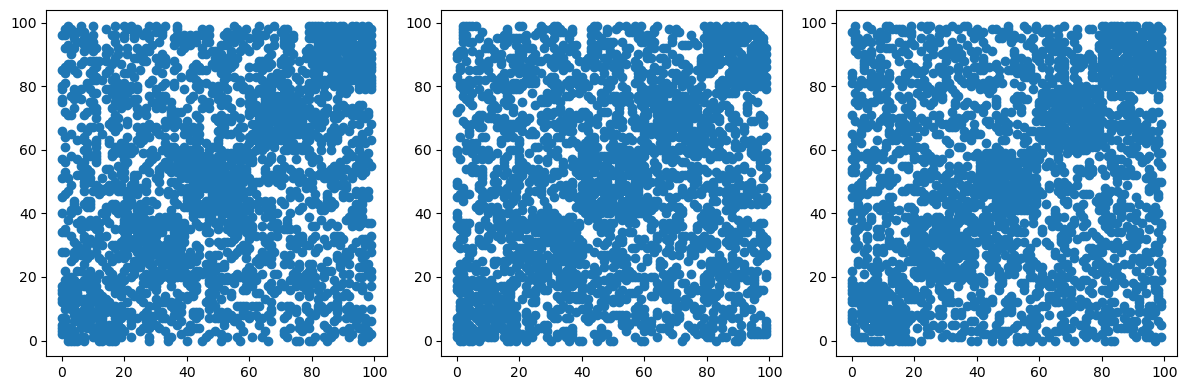

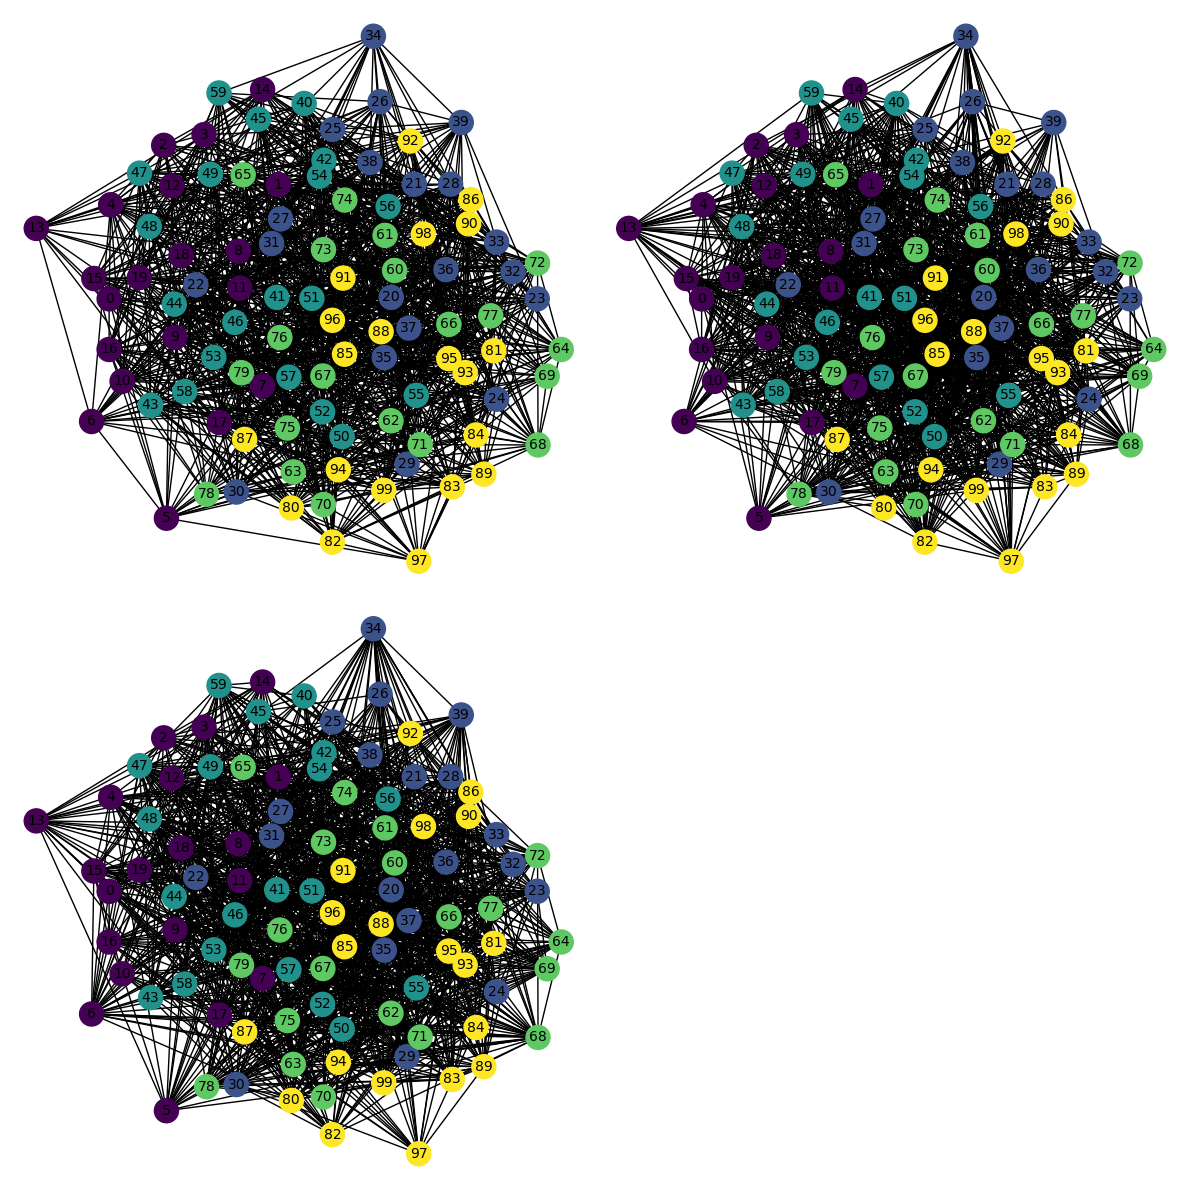

In [94]:
import numpy as np
from utils import computeDegreeMatrix, spectralClustering
from sklearn.cluster import SpectralClustering
from tslearn.clustering import KernelKMeans
from sklearn.cluster import KMeans
import kernel_kmeans
%run GraphCreation.ipynb

[]

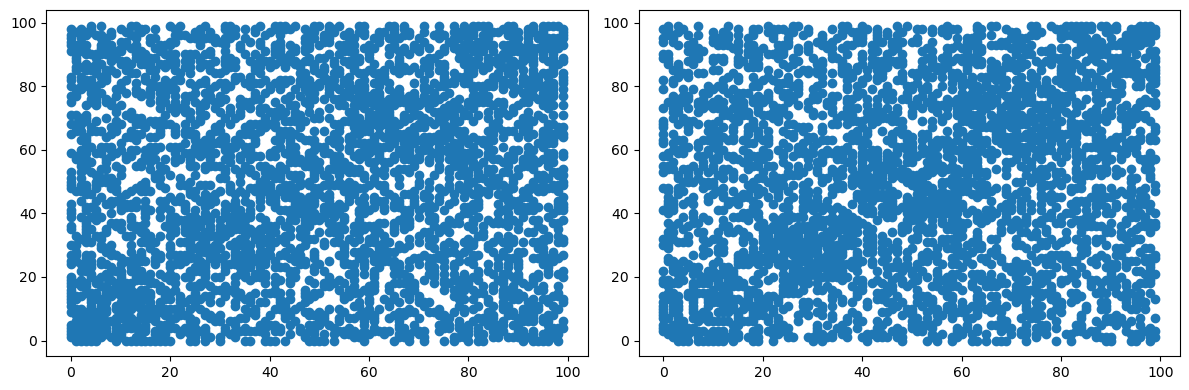

In [95]:
n = 100
M = 2
k = 5

prob = np.full((k,M),0.5)
prob_prime = np.full((k,k,M),0.3)
clusters_size = k*[20]

matrix,index_cluster = graph_creation_1(n,M,k,clusters_size,prob,prob_prime)


fig, axs = plt.subplots(1, M, figsize=(12, 4))  # 1 row, 3 columns, total figure size is (15, 5) inches

for i in range(M):
  x,y = np.where(matrix[:,:,i] == 1)
  axs[i].scatter(x,y)

plt.tight_layout()
plt.plot()

[]

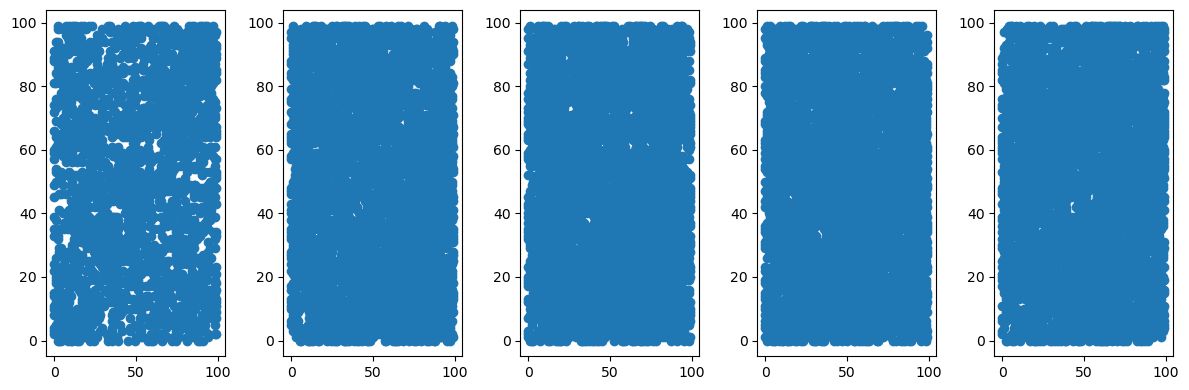

In [113]:
n = 100
M = 5
k = 5

prob = np.full((k,M),0.4)

prob_prime1 = np.full((k,k),0.2)
prob_prime2 = np.full((k,k),0.4)
prob_prime3 = np.full((k,k),0.4)
prob_prime4 = np.full((k,k),0.4)
prob_prime5 = np.full((k,k),0.4)

prob_prime = np.stack((prob_prime1,prob_prime2, prob_prime3, prob_prime4, prob_prime5),axis=2)
clusters_size = k*[20]

matrix,index_cluster = graph_creation_1(n,M,k,clusters_size,prob,prob_prime)

fig, axs = plt.subplots(1, M, figsize=(12, 4))  # 1 row, 3 columns, total figure size is (15, 5) inches

for i in range(M):
  x,y = np.where(matrix[:,:,i] == 1)
  axs[i].scatter(x,y)

plt.tight_layout()
plt.plot()

## SC-SUM

In [97]:
def SC_SUM(adj_matrix, k, normalized = False):
    """
    Spectral Clustering with summation of adjacency matrices
    See Eq 15 of the paper

    Parameters
    ----------
    adj_matrix : numpy array of shape (M,n,n)
    k (int): number of target clusters
    normalized (bool): whether to use normalized adjacency matrces

    Returns
    -------
    numpy array of shape (n,k) : cluster assignment matrix
    """
    n,_,M = adj_matrix.shape # M is the number of clusters, n is the number of nodes
    
    if normalized:
        W = np.zeros((n,n))
        for i in range(M):
            W_i = adj_matrix[:,:,i]
            D_i = computeDegreeMatrix(W_i)
            W += (np.sqrt(np.linalg.inv(D_i))) @ W_i @ (np.sqrt(np.linalg.inv(D_i)))

        return spectralClustering(W, k)


    else:
        W = np.sum(adj_matrix, axis=-1) #summation of the M adjacency matrices
        return spectralClustering(W, k)  

In [98]:
SC_SUM(matrix, 5, normalized = False)

array([3, 3, 0, 0, 3, 1, 3, 0, 1, 3, 0, 3, 0, 3, 3, 3, 0, 3, 3, 3, 0, 0,
       4, 0, 1, 0, 0, 1, 0, 0, 2, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       3, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 3, 0, 1, 1, 0, 1, 1, 0, 1, 0,
       1, 1, 3, 3, 0, 1, 1, 0, 0, 0, 0, 0], dtype=int32)

## K-KMeans

In [99]:
def K_KMeans(adj_matrix, d, k):
    """
    Kernel KMeans applied on the summation of spectral kernels of the adjacency matrices
    See Eq 17 of the paper

    Parameters
    ----------
    adj_matrix : numpy array of shape (M,n,n)
    d (int): number of eigenvectors to use
    k (int): number of target clusters

    Returns
    -------
    numpy array of shape (n,k) : cluster assignment matrix
    """
    n, _, M = adj_matrix.shape

    W = np.zeros((n,n))
    for i in range(M):
        W_i = adj_matrix[:,:, i]
        D_i = computeDegreeMatrix(W_i)
        Lsym_i = (np.sqrt(np.linalg.inv(D_i))) @ (D_i - W_i) @ (np.sqrt(np.linalg.inv(D_i)))
        eigenvalues, eigenvectors = np.linalg.eig(Lsym_i)
        sorted_eigvecs = eigenvectors[:,np.argsort(eigenvalues)[:d]] #shape (n,d)

        K_i = np.zeros((n,n))
        for j in range(d):
            K_i += sorted_eigvecs[:,j] @ sorted_eigvecs[:,j].T
        
        W += K_i
    
    return SpectralClustering(n_clusters=k).fit(W).labels_
    



In [100]:
K_KMeans(matrix, 8, 5)

/Users/Meilame/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_spectral.py:484: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


array([2, 0, 0, 0, 0, 3, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0,
       0, 0, 0, 3, 0, 2, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 4, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 3,
       0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 4, 0,
       0, 0, 0, 3, 0, 3, 0, 0, 0, 0, 0, 0], dtype=int32)

## SC-AL

In [101]:
def SC_AL(adj_matrix, k):
    """
    Spectral Clustering with average of Laplacian matrices
    See Eq 18 of the paper

    Parameters
    ----------
    adj_matrix : numpy array of shape (M,n,n)
    k (int): number of target clusters

    Returns
    -------
    numpy array of shape (n,k) : cluster assignment matrix
    """
    
    n,_,M = adj_matrix.shape # M is the number of clusters, n is the number of nodes

    #Computation of the average on the M Laplacian matrices
    L = np.zeros((n,n))
    for i in range(M):
        W_i = adj_matrix[:,:, i]
        D_i = computeDegreeMatrix(W_i)
        Lrw_i = np.linalg.inv(D_i) @ (D_i - W_i)
        L += Lrw_i
    
    L = L/M

    eigvals, eigvecs = np.linalg.eig(L)
    eigvals = np.real(eigvals)
    eigvecs = np.real(eigvecs)
    U = eigvecs[:,np.argsort(eigvals)[:k]] # eigenvectors corrresponding to the k smallest eigenvalues; shape (n,k)

    kmeans = KMeans(n_clusters=k).fit(U)

    return kmeans.labels_

In [114]:
SC_AL(matrix, 5)

array([0, 2, 3, 4, 0, 3, 1, 2, 3, 3, 2, 3, 3, 3, 4, 4, 1, 2, 3, 3, 0, 2,
       3, 3, 1, 1, 2, 2, 1, 2, 3, 1, 0, 3, 3, 0, 3, 2, 2, 3, 1, 4, 1, 0,
       2, 2, 4, 2, 1, 2, 2, 0, 2, 4, 3, 0, 2, 1, 2, 2, 1, 3, 0, 2, 4, 3,
       3, 3, 4, 1, 2, 3, 2, 0, 0, 4, 0, 4, 3, 0, 1, 0, 0, 1, 1, 2, 2, 1,
       1, 1, 2, 3, 1, 4, 1, 3, 3, 4, 1, 3], dtype=int32)